# Building an ANN

build a four-layered model that is able to determine whether a client will default the next payment. To do this, we'll use the custom modules methodology.

In [2]:
# import the required libs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# read dccc_prepared.csv
data = pd.read_csv("dccc_prepared.csv")

In [7]:
# seperate the features from the target. The target is stored in the first column
x = data.iloc[:,:-1] #everything at and after the first index
y = data["default payment next month"]

In [8]:
# split the training data 60:20:20, random state 0
x_shuffle = x.sample(frac=1, random_state=0)
y_shuffle = y.sample(frac=1, random_state=0)
x_new, x_test_2, y_new, y_test_2 = train_test_split(x_shuffle, y_shuffle, test_size=0.2, random_state=0)
dev_per = x_test_2.shape[0]/x_new.shape[0]
x_train_2, x_dev_2, y_train_2, y_dev_2 = train_test_split(x_new, y_new, test_size=dev_per, random_state=0)

In [9]:
print(x_train_2.shape, y_train_2.shape)
print(x_dev_2.shape, y_dev_2.shape)
print(x_test_2.shape, y_test_2.shape)

(28036, 22) (28036,)
(9346, 22) (9346,)
(9346, 22) (9346,)


In [13]:
# convert the validation and testing sets into tensors, considering the features matrix should be of the float type, while the target matrix should not
# leave the training sets unconverted as they'll be changed in a bit
# x_train = torch.tensor(x_train2.values).float()
# y_train = torch.tensor(y_train2.values).float()
x_dev = torch.tensor(x_dev_2.values).float()
y_dev = torch.tensor(y_dev_2.values)
x_test = torch.tensor(x_test_2.values).float()
y_test = torch.tensor(y_test_2.values)

Build a custom module class for defining the layers of the network. Include a forward function that specifies the activation functions that will be applied to the output of each layer. Use `ReLU` for all layers except the output, which should use `log_softmax`.

In [18]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(input_size, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 10)
        self.linear4 = nn.Linear(10, 2)
    def forward(self, x):
        z = F.relu(self.linear1(x))
        z = F.relu(self.linear2(z))
        z = F.relu(self.linear3(z))
        o = F.log_softmax(self.linear2(z), dim=1)
        return o

Instantiate the model and define all the variables required to train the model. `Epochs` should be 50 and `batch_size` should be 128. Learning rate should be `0.001`.

In [19]:
model = Classifier(x_train_2.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50
batch_size = 128

Train the network using the training sets data. Use the validation sets to measure performance. To do this, save the loss and the accuracy for both the training and validation sets in each  epoch.

In [21]:
train_losses, dev_losses, train_acc, dev_acc = [], [], [], []
for e in range(epochs):
    x_, y_ = shuffle(x_train_2, y_train_2)
    running_loss = 0
    running_acc = 0
    iterations = 0
    for i in range(0, len(x_), batch_size):
        iterations += 1
        b = i + batch_size
        x_batch = torch.tensor(x_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
    dev_loss = 0
    acc = 0
    with torch.no_grad():
        pred_dev = model(x_dev)
        dev_loss = criterion(pred_dev, y_dev)
        ps_dev = torch.exp(pred_dev)
        top_p, top_class_dev = ps_dev.topk(1,dim=1)
        acc = accuracy_score(y_dev, top_class_dev)
    train_losses.append(running_loss/iterations)
    dev_losses.append(dev_loss)
    train_acc.append(running_acc/iterations)
    dev_acc.append(acc)
    print(
        "Epoch: {}/{}.. ".format(e+1, epochs), 
        "Training Loss: {:.3f}..".format(running_loss/iterations),
        "Validation Loss: {:.3f}..".format(dev_loss),
        "Training Accuracy: {:.3f}..".format(running_acc/iterations),
        "Validation Accuracy: {:.3f}..".format(acc))
        

Epoch: 1/50..  Training Loss: 1.652.. Validation Loss: 0.748.. Training Accuracy: 0.413.. Validation Accuracy: 0.504..
Epoch: 2/50..  Training Loss: 0.693.. Validation Loss: 0.675.. Training Accuracy: 0.545.. Validation Accuracy: 0.560..
Epoch: 3/50..  Training Loss: 0.666.. Validation Loss: 0.653.. Training Accuracy: 0.580.. Validation Accuracy: 0.581..
Epoch: 4/50..  Training Loss: 0.642.. Validation Loss: 0.629.. Training Accuracy: 0.632.. Validation Accuracy: 0.657..
Epoch: 5/50..  Training Loss: 0.624.. Validation Loss: 0.619.. Training Accuracy: 0.660.. Validation Accuracy: 0.658..
Epoch: 6/50..  Training Loss: 0.617.. Validation Loss: 0.614.. Training Accuracy: 0.669.. Validation Accuracy: 0.666..
Epoch: 7/50..  Training Loss: 0.613.. Validation Loss: 0.613.. Training Accuracy: 0.675.. Validation Accuracy: 0.659..
Epoch: 8/50..  Training Loss: 0.609.. Validation Loss: 0.604.. Training Accuracy: 0.676.. Validation Accuracy: 0.677..
Epoch: 9/50..  Training Loss: 0.604.. Validation

Print the loss of both sets

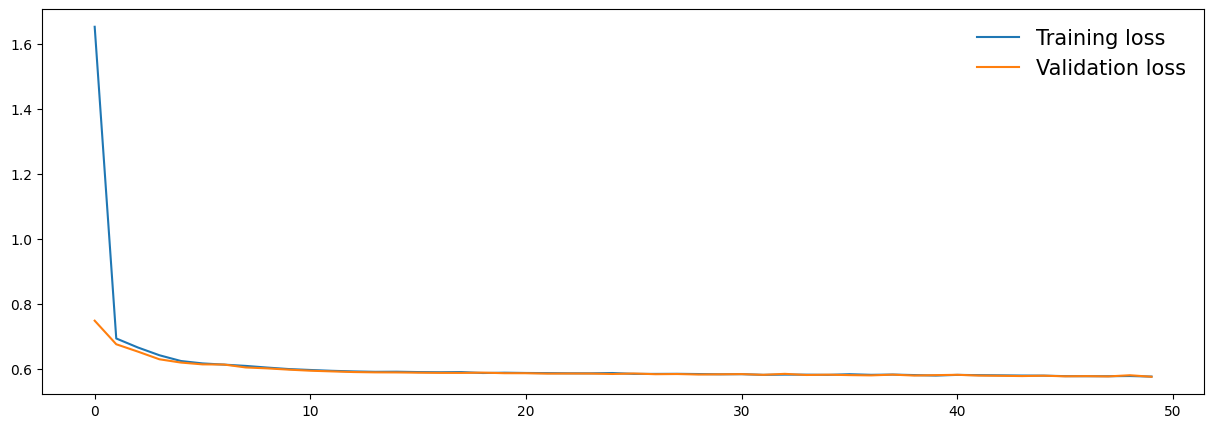

In [22]:
fig = plt.figure(figsize=(15,5))
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

Plot the accuracy of both setsPlot the accuracy of both sets

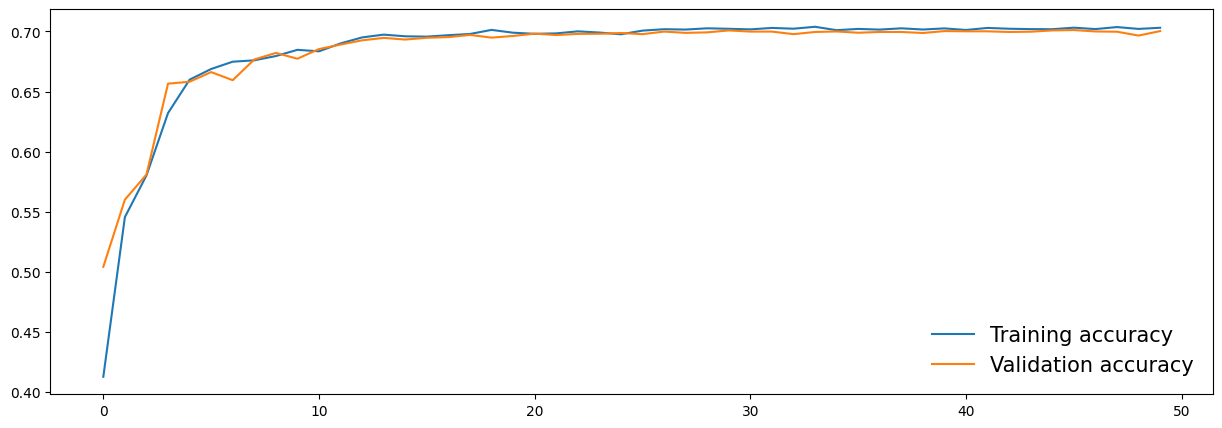

In [24]:
fig = plt.figure(figsize=(15,5))
plt.plot(train_acc, label='Training accuracy')
plt.plot(dev_acc, label='Validation accuracy')
plt.legend(frameon=False, fontsize=15)
plt.show()

I don't really understand this very well, and I'll need to re-read this portion of the chapter. I feel like it kinda glazes over the module and training segments with really broad statements. Oh well